In [1]:
# set up some environmental dependencies
import time, sys, os
import h5py
import numpy as np
from astropy.table import Table
import scipy
from astropy import coordinates
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
from astropy.coordinates import SkyCoord
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table
import astropy.cosmology.units as cu
import astropy.units as u
from matplotlib.pyplot import *
import seaborn as sns
import numpy as np, matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
from astropy.io import ascii
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
import matplotlib
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# standard imports for my work
from bpt_utils import *
from read_transients_data import *
from correct_redshift_evolution import *
from generate_bkg_galaxies import *
from helper_functions import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['image.origin'] = 'lower'
sns.set_context('talk') 
sns.set(font_scale=1.4)
sns.set_palette('colorblind')
sns.set_style('ticks')
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma', 'Verdana', 'Lucida Grande', 'DejaVu Sans']


In [2]:
dsa110_frbs = pd.read_excel('frbs_data/DSA110-FRBs.xlsx', sheet_name='frb_params', 
                            engine='openpyxl', keep_default_na=False, na_values='')
dsa110_frbs = dsa110_frbs.drop(0)
pixel_scales = {"DECam/r": 0.2637,
                "PS1/r": 0.258,
                "WASP/r": 0.18,
                "WIRC/J": 0.2487,
                "DEIMOS/R": 0.1185
               }

In [3]:
dsa_frbs = pd.read_csv("frbs_data/dsa_frbs.csv")
dsa_frbs = dsa_frbs[dsa_frbs["sed_done?"]=="Y"].reset_index()

lum_dist = []
ra_offsets = []
dec_offsets = []
ra_errs = []
dec_errs = []
half_light = []
ages = []
seps = []

for frb in dsa_frbs["frb_name"]:
    df = dsa_frbs[dsa_frbs["frb_name"]==frb].reset_index()
    lum_dist.append(cosmo.luminosity_distance(df.redshift[0]).value)
    host_pos = SkyCoord(df["host_loc (hms, dms)"][0].split(", ")[0], 
                        df["host_loc (hms, dms)"][0].split(", ")[1], 
                        unit=(u.hourangle, u.deg), frame='icrs')
    frb_pos, e_ra, e_dec = get_ra_dec_errs(frb)
    ra_offset = frb_pos[0].spherical_offsets_to(host_pos)[0].arcsec
    dec_offset = frb_pos[0].spherical_offsets_to(host_pos)[1].arcsec
    ang_dist = cosmo.angular_diameter_distance(df.redshift[0]).to(u.kpc)
    ra_offset = (ra_offset/3600)*(3.14/180)*ang_dist.value
    dec_offset = (dec_offset/3600)*(3.14/180)*ang_dist.value
    e_ra = (e_ra/3600)*(3.14/180)*ang_dist.value
    e_dec = (e_dec/3600)*(3.14/180)*ang_dist.value
    ra_offsets.append(ra_offset)
    dec_offsets.append(dec_offset)
    ra_errs.append(e_ra)
    dec_errs.append(e_dec)
    half_light.append((df["half_light_radius (arcsec)"][0]/3600)*(3.14/180)*ang_dist.value)
    seps.append((frb_pos[0].separation(host_pos).arcsec/3600)*(3.14/180)*ang_dist.value)

dsa_frbs["lum_dist (Mpc)"] = lum_dist
dsa_frbs["ra_proj_gal_dist (kpc)"] = ra_offsets
dsa_frbs["dec_proj_gal_dist (kpc)"] = dec_offsets
dsa_frbs["ra_proj_gal_dist_err (kpc)"] = np.asarray(ra_errs)
dsa_frbs["dec_proj_gal_dist_err (kpc)"] = np.asarray(dec_errs)
dsa_frbs["half_light_radius (kpc)"] = half_light
dsa_frbs["proj_gal_dist (kpc)"] = np.sqrt((dsa_frbs["ra_proj_gal_dist (kpc)"])**2 + (dsa_frbs["dec_proj_gal_dist (kpc)"])**2)
dsa_frbs["proj_gal_dist_err (kpc)"] = np.sqrt((dsa_frbs["ra_proj_gal_dist_err (kpc)"])**2 + (dsa_frbs["dec_proj_gal_dist_err (kpc)"])**2)


In [4]:
# Read in FRBs Offsets Data

# Literature data = Mannings et al., Woodland et al.
frb_offset, frb_err = read_frbs_offsets_literature_data()
frb_offset_norm, frb_err_norm = read_frbs_normalized_offsets_literature_data()


In [5]:
ULX_offset, ULX_err = read_ULXsources_offsets()

sgrb_offset, sgrb_err = read_sGRB_offsets()
sgrb_offset_norm, sgrb_err_norm = read_sGRB_normalized_offsets()

lgrb_offset, lgrb_err = read_lGRB_offsets()
lgrb_offset_norm, lgrb_err_norm = read_lGRB_normalized_offsets()

ccsn_offset, ccsn_err = read_CCSNe_offsets()
ccsn_offset_norm, ccsn_err_norm = read_CCSNe_normalized_offsets()

typeIa_offset, typeIa_err = read_TypeIaSNe_offsets()
typeIa_offset_norm, typeIa_err_norm = read_TypeIaSNe_normalized_offsets()

slsn_offset, slsn_err = read_SLSNe_offsets()
slsn_offset, slsn_err = np.array(slsn_offset), np.array(slsn_err)
mask = np.logical_and(slsn_offset>0, slsn_err>0)
slsn_offset, slsn_err = slsn_offset[mask], slsn_err[mask]
slsn_offset_norm, slsn_err_norm = read_SLSNe_normalized_offsets()

mw_half_light_rad = 3.43  # Half-light radius in kpc (Lian et al. 2024)
mw_sattelites_offsets_norm = read_MW_sattelites_normalized_offsets()
mw_sattelites_offsets = np.array(mw_sattelites_offsets_norm)*mw_half_light_rad
mw_gc_offsets_norm = read_MW_GCs_normalized_offsets()
mw_gc_offsets = np.array(mw_gc_offsets_norm)*mw_half_light_rad


In [6]:
dsa_frbs_gold = dsa_frbs[dsa_frbs["sample"]=="Gold"].reset_index()

half_size = 1000 // 2
deciding_toss = [1] * half_size + [0] * (1000 - half_size)
import random
random.shuffle(deciding_toss)

bins = 10**np.arange(-1, 2, 0.05)
bins_ = []
for i in range(len(bins)-1):
    bins_.append(bins[i])
    bins_.append(bins[i+1])

frbs_outs, sgrb_outs, lgrb_outs, ccsn_outs, ulx_outs, slsn_outs, typeIa_outs = [], [], [], [], [], [], []
pvalues_sgrb, pvalues_lgrb, pvalues_ccsn, pvalues_ulx, pvalues_slsn, pvalues_typeIa = [], [], [], [], [], []

samples_frb_all = []
for k in tqdm(range(1000)): 
    samples_frb, samples_sgrb, samples_lgrb, samples_ccsn, samples_ulx, samples_slsn, samples_typeIa = [], [], [], [], [], [], []
    
    for i in range(len(dsa_frbs_gold)):
        samples_frb = samples_frb + [generate_equidistant_offsets_ellipse(
            dsa_frbs_gold["ra_proj_gal_dist (kpc)"][i], dsa_frbs_gold["dec_proj_gal_dist (kpc)"][i], 
            dsa_frbs_gold["ra_proj_gal_dist_err (kpc)"][i], dsa_frbs_gold["dec_proj_gal_dist_err (kpc)"][i], 
            deciding_toss[k])]

    for i in range(len(frb_offset)):
        samples_frb = samples_frb + generate_equidistant_offsets_circle(
            frb_offset[i], frb_err[i], deciding_toss[k])

    samples_frb_all = samples_frb_all + samples_frb

    for i in range(len(sgrb_offset)):
        samples_sgrb = samples_sgrb + generate_equidistant_offsets_circle(
            sgrb_offset[i], sgrb_err[i], deciding_toss[k])

    for i in range(len(lgrb_offset)):
        samples_lgrb = samples_lgrb + generate_equidistant_offsets_circle(
            lgrb_offset[i], lgrb_err[i], deciding_toss[k])

    for i in range(len(ccsn_offset)):
        samples_ccsn = samples_ccsn + generate_equidistant_offsets_circle(
            ccsn_offset[i], ccsn_err[i], deciding_toss[k])

    for i in range(len(ULX_offset)):
        samples_ulx = samples_ulx + generate_equidistant_offsets_circle(
            ULX_offset[i], ULX_err[i], deciding_toss[k])
        
    for i in range(len(slsn_offset)):
        samples_slsn = samples_slsn + generate_equidistant_offsets_circle(
            slsn_offset[i], slsn_err[i], deciding_toss[k])
        
    for i in range(len(typeIa_offset)):
        samples_typeIa = samples_typeIa + generate_equidistant_offsets_circle(
            typeIa_offset[i], typeIa_err[i], deciding_toss[k])

    pvalues_sgrb.append(stats.ks_2samp(samples_sgrb, samples_frb).pvalue)
    pvalues_lgrb.append(stats.ks_2samp(samples_lgrb, samples_frb).pvalue)
    pvalues_ccsn.append(stats.ks_2samp(samples_ccsn, samples_frb).pvalue)
    pvalues_ulx.append(stats.ks_2samp(samples_ulx, samples_frb).pvalue)
    pvalues_slsn.append(stats.ks_2samp(samples_slsn, samples_frb).pvalue)
    pvalues_typeIa.append(stats.ks_2samp(samples_typeIa, samples_frb).pvalue)
        
    frbs_out = plt.hist(samples_frb, bins=bins, alpha=0, histtype="step", 
                        color="black", lw=1, cumulative=True, density=True)
    frbs_outs.append(frbs_out[0])
        
    sgrb_out = plt.hist(samples_sgrb, bins=bins, alpha=0, histtype="step", 
                        color="crimson", lw=1, cumulative=True, density=True)
    sgrb_outs.append(sgrb_out[0])
    
    lgrb_out = plt.hist(samples_lgrb, bins=bins, alpha=0, histtype="step", 
                        color="orange", lw=1, cumulative=True, density=True)
    lgrb_outs.append(lgrb_out[0])

    ccsn_out = plt.hist(samples_ccsn, bins=bins, alpha=0, histtype="step", 
                        color="orange", lw=1, cumulative=True, density=True)
    ccsn_outs.append(ccsn_out[0])

    ulx_out = plt.hist(samples_ulx, bins=bins, alpha=0, histtype="step", 
                       color="orange", lw=1, cumulative=True, density=True)
    ulx_outs.append(ulx_out[0])

    slsn_out = plt.hist(samples_slsn, bins=bins, alpha=0, histtype="step", 
                        color="magenta", lw=1, cumulative=True, density=True)
    slsn_outs.append(slsn_out[0])

    typeIa_out = plt.hist(samples_typeIa, bins=bins, alpha=0, histtype="step", 
                          color="turquoise", lw=1, cumulative=True, density=True)
    typeIa_outs.append(typeIa_out[0])

plt.close()

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 21.94it/s]


In [7]:
bins = 10**np.arange(-1, np.log10(50), 0.05)
bins_ = []
for i in range(len(bins)-1):
    bins_.append(bins[i])
    bins_.append(bins[i+1])

frbs_outs_norm, sgrb_outs_norm, lgrb_outs_norm, ccsn_outs_norm, slsn_outs_norm, typeIa_outs_norm = [], [], [], [], [], []
pvalues_sgrb_norm, pvalues_lgrb_norm, pvalues_ccsn_norm, pvalues_slsn_norm, pvalues_typeIa_norm = [], [], [], [], []

samples_frb_all_norm = []

for k in tqdm(range(1000)): 
    samples_frb_norm, samples_sgrb_norm, samples_lgrb_norm, samples_ccsn_norm, samples_slsn_norm, samples_typeIa_norm = [], [], [], [], [], []
    
    for i in range(len(dsa_frbs_gold)):
        samples_frb_norm = samples_frb_norm + [generate_equidistant_offsets_ellipse(
            dsa_frbs_gold["ra_proj_gal_dist (kpc)"][i], 
            dsa_frbs_gold["dec_proj_gal_dist (kpc)"][i],
            dsa_frbs_gold["ra_proj_gal_dist_err (kpc)"][i], 
            dsa_frbs_gold["dec_proj_gal_dist_err (kpc)"][i], 
            deciding_toss[k])/dsa_frbs_gold["half_light_radius (kpc)"][i]]

    for i in range(len(frb_offset_norm)):
        samples_frb_norm = samples_frb_norm + generate_equidistant_offsets_circle(
            frb_offset_norm[i], frb_err_norm[i], deciding_toss[k])

    samples_frb_all_norm = samples_frb_all_norm + samples_frb_norm
    
    for i in range(len(sgrb_offset_norm)):
        samples_sgrb_norm = samples_sgrb_norm + generate_equidistant_offsets_circle(
            sgrb_offset_norm[i], sgrb_err_norm[i], deciding_toss[k])

    for i in range(len(lgrb_offset_norm)):
        samples_lgrb_norm = samples_lgrb_norm + generate_equidistant_offsets_circle(
            lgrb_offset_norm[i], lgrb_err_norm[i], deciding_toss[k])

    for i in range(len(ccsn_offset_norm)):
        samples_ccsn_norm = samples_ccsn_norm + generate_equidistant_offsets_circle(
            ccsn_offset_norm[i], ccsn_err_norm[i], deciding_toss[k])

    for i in range(len(slsn_offset_norm)):
        samples_slsn_norm = samples_slsn_norm + generate_equidistant_offsets_circle(
            slsn_offset_norm[i], slsn_err_norm[i], deciding_toss[k])

    for i in range(len(typeIa_offset_norm)):
        samples_typeIa_norm = samples_typeIa_norm + generate_equidistant_offsets_circle(
            typeIa_offset_norm[i], typeIa_err_norm[i], deciding_toss[k])

    pvalues_sgrb_norm.append(stats.ks_2samp(samples_sgrb_norm, samples_frb_norm).pvalue)
    pvalues_lgrb_norm.append(stats.ks_2samp(samples_lgrb_norm, samples_frb_norm).pvalue)
    pvalues_ccsn_norm.append(stats.ks_2samp(samples_ccsn_norm, samples_frb_norm).pvalue)
    pvalues_slsn_norm.append(stats.ks_2samp(samples_slsn_norm, samples_frb_norm).pvalue)
    pvalues_typeIa_norm.append(stats.ks_2samp(samples_typeIa_norm, samples_frb_norm).pvalue)

    frbs_out = plt.hist(samples_frb_norm, bins=bins, alpha=0, histtype="step", 
                        color="black", lw=1, cumulative=True, density=True)
    frbs_outs_norm.append(frbs_out[0])
        
    sgrb_out = plt.hist(samples_sgrb_norm, bins=bins, alpha=0, histtype="step", 
                        color="crimson", lw=1, cumulative=True, density=True)
    sgrb_outs_norm.append(sgrb_out[0])
    
    lgrb_out = plt.hist(samples_lgrb_norm, bins=bins, alpha=0, histtype="step", 
                        color="orange", lw=1, cumulative=True, density=True)
    lgrb_outs_norm.append(lgrb_out[0])

    ccsn_out = plt.hist(samples_ccsn_norm, bins=bins, alpha=0, histtype="step", 
                        color="orange", lw=1, cumulative=True, density=True)
    ccsn_outs_norm.append(ccsn_out[0])

    slsn_out = plt.hist(samples_slsn_norm, bins=bins, alpha=0, histtype="step", 
                        color="magenta", lw=1, cumulative=True, density=True)
    slsn_outs_norm.append(ccsn_out[0])

    typeIa_out = plt.hist(samples_typeIa_norm, bins=bins, alpha=0, histtype="step", 
                          color="turquoise", lw=1, cumulative=True, density=True)
    typeIa_outs_norm.append(typeIa_out[0])

plt.close()

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.84it/s]


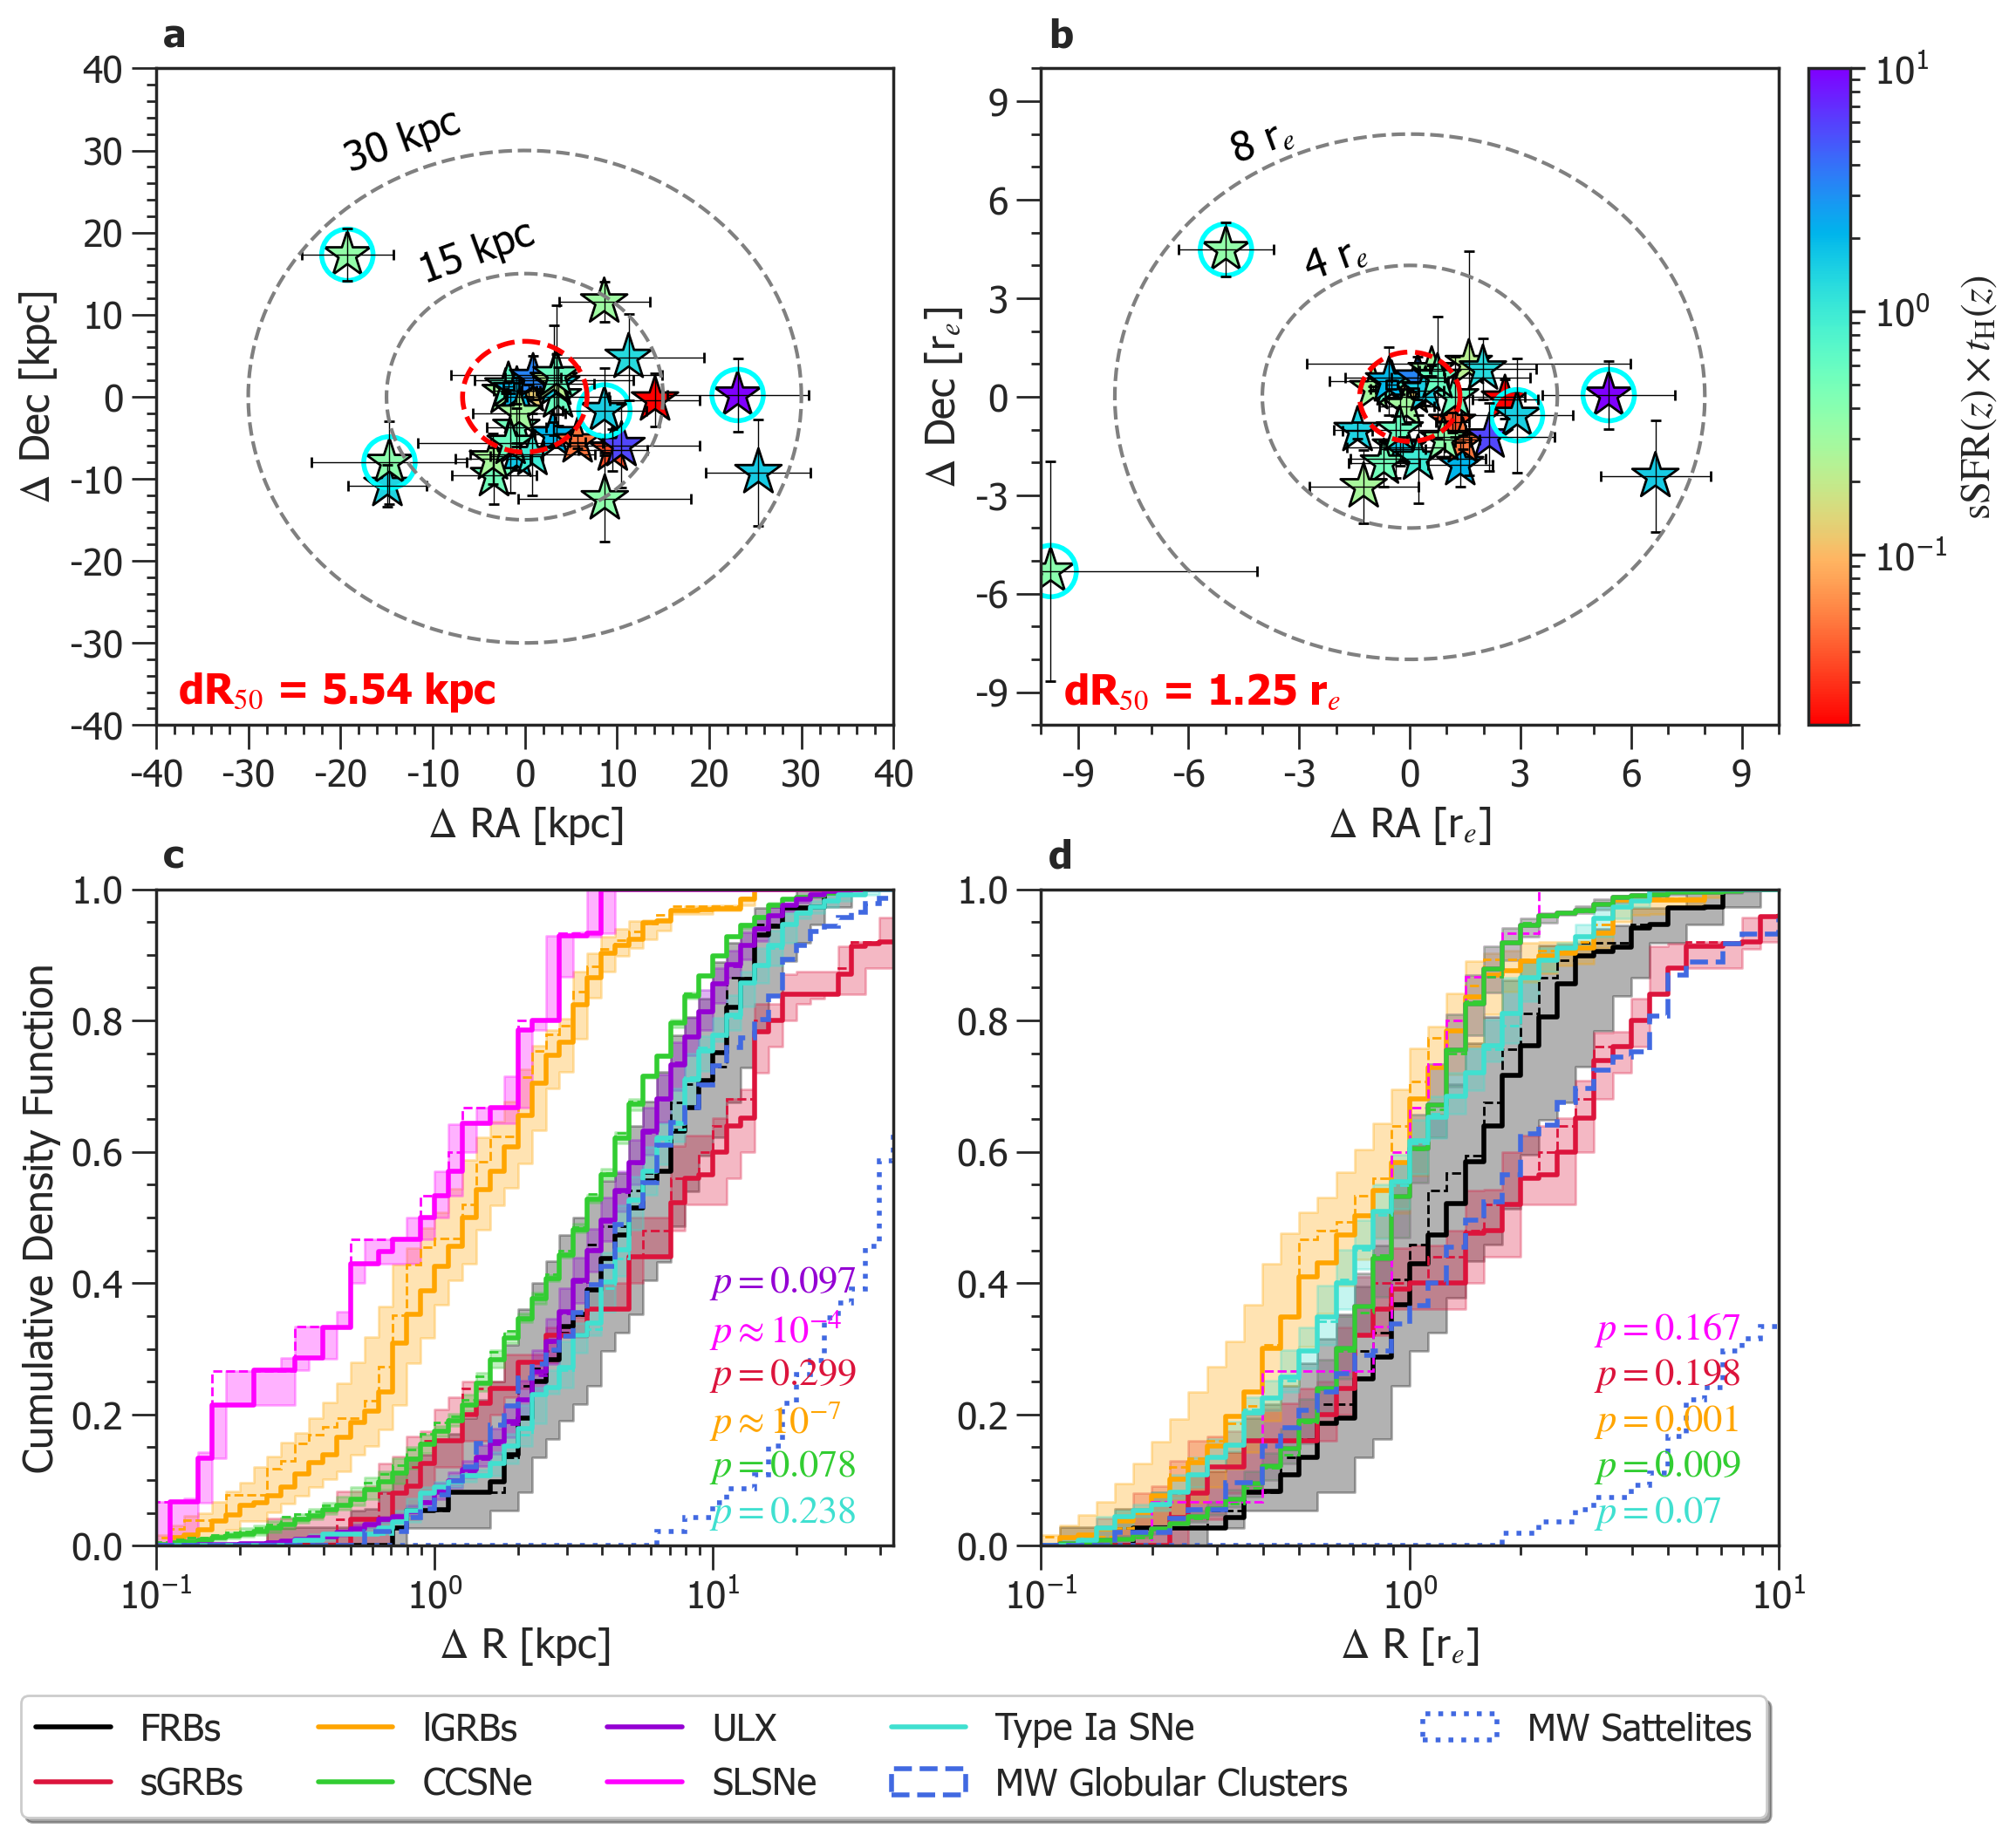

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 11))
plt.subplots_adjust(hspace=0.25)

im = axes[0, 0].errorbar(dsa_frbs["ra_proj_gal_dist (kpc)"], dsa_frbs["dec_proj_gal_dist (kpc)"],
                         xerr = dsa_frbs["ra_proj_gal_dist_err (kpc)"],
                         yerr = dsa_frbs["dec_proj_gal_dist_err (kpc)"],
                         ecolor="black", fmt="o", capsize=2, elinewidth=0.5,
                         markerfacecolor="none", markeredgecolor="none")
im = axes[0, 0].scatter(dsa_frbs["ra_proj_gal_dist (kpc)"], dsa_frbs["dec_proj_gal_dist (kpc)"], 
                        c = (dsa_frbs["ssfr"])*cosmo.age(dsa_frbs["redshift"]), norm=matplotlib.colors.LogNorm(),
                        cmap="rainbow_r", marker="*", s=400, edgecolors='black')
im.set_clim(2e-2, 10)

axes[0, 0].scatter(dsa_frbs[dsa_frbs["sample"]=="Silver"]["ra_proj_gal_dist (kpc)"],
                   dsa_frbs[dsa_frbs["sample"]=="Silver"]["dec_proj_gal_dist (kpc)"], 
                   color="None", marker="o", s=450, edgecolors='cyan', lw=2)

axes[0, 0].xaxis.set_major_locator(MultipleLocator(10)) 
axes[0, 0].xaxis.set_minor_locator(MultipleLocator(2))                                                                                                                                                                                                                         
axes[0, 0].yaxis.set_major_locator(MultipleLocator(10))                                                                                                                                                                                                                     
axes[0, 0].yaxis.set_minor_locator(MultipleLocator(2)) 
axes[0, 0].tick_params(direction='out', length=6, width=1, top=False, right=False)
axes[0, 0].tick_params(which='both', width=1)
axes[0, 0].tick_params(which='major', length=10)
axes[0, 0].tick_params(which='minor', length=4)
axes[0, 0].set_xlim(-40, 40)
axes[0, 0].set_ylim(-40, 40)

im = axes[0, 1].errorbar(dsa_frbs["ra_proj_gal_dist (kpc)"]/dsa_frbs["half_light_radius (kpc)"],
                         dsa_frbs["dec_proj_gal_dist (kpc)"]/dsa_frbs["half_light_radius (kpc)"],
                         xerr = dsa_frbs["ra_proj_gal_dist_err (kpc)"]/dsa_frbs["half_light_radius (kpc)"],
                         yerr = dsa_frbs["dec_proj_gal_dist_err (kpc)"]/dsa_frbs["half_light_radius (kpc)"],
                         ecolor="black", fmt="o", capsize=2, elinewidth=0.5,
                         markerfacecolor="none", markeredgecolor="none")
im = axes[0, 1].scatter(dsa_frbs["ra_proj_gal_dist (kpc)"]/dsa_frbs["half_light_radius (kpc)"],
                        dsa_frbs["dec_proj_gal_dist (kpc)"]/dsa_frbs["half_light_radius (kpc)"], 
                        c = dsa_frbs["ssfr"]*cosmo.age(dsa_frbs["redshift"]), norm=matplotlib.colors.LogNorm(),
                        cmap="rainbow_r", marker="*", s=400, edgecolors='black')
im.set_clim(2e-2, 10)

axes[0, 1].scatter(dsa_frbs[dsa_frbs["sample"]=="Silver"]["ra_proj_gal_dist (kpc)"]/dsa_frbs[dsa_frbs["sample"]=="Silver"]["half_light_radius (kpc)"],
                   dsa_frbs[dsa_frbs["sample"]=="Silver"]["dec_proj_gal_dist (kpc)"]/dsa_frbs[dsa_frbs["sample"]=="Silver"]["half_light_radius (kpc)"], 
                   color="None", marker="o", s=450, edgecolors='cyan', lw=2)

axes[0, 1].xaxis.set_major_locator(MultipleLocator(3)) 
axes[0, 1].xaxis.set_minor_locator(MultipleLocator(1))                                                                                                                                                                                                                         
axes[0, 1].yaxis.set_major_locator(MultipleLocator(3))                                                                                                                                                                                                                     
axes[0, 1].yaxis.set_minor_locator(MultipleLocator(1)) 
axes[0, 1].tick_params(direction='out', length=6, width=1, top=False, right=False)
axes[0, 1].tick_params(which='both', width=1)
axes[0, 1].tick_params(which='major', length=10)
axes[0, 1].tick_params(which='minor', length=4)
axes[0, 1].set_xlim(-10, 10)
axes[0, 1].set_ylim(-10, 10)


theta = np.linspace(0, 2*np.pi, 360)
radius = 15
a = radius * np.cos(theta)
b = radius * np.sin(theta)
axes[0, 0].plot(a, b, color="gray", ls="--")
radius = 30
a = radius * np.cos(theta)
b = radius * np.sin(theta)
axes[0, 0].plot(a, b, color="gray", ls="--")
avg_dR = 6.75
a = avg_dR * np.cos(theta)
b = avg_dR * np.sin(theta)
axes[0, 0].plot(a, b, color="red", ls="--", lw=2)
axes[0, 0].text(.25, .89, "30 kpc", color="black", ha='left', va='center', 
             transform=axes[0, 0].transAxes, rotation = 20)
axes[0, 0].text(.35, .72, "15 kpc", color="black", ha='left', va='center', 
             transform=axes[0, 0].transAxes, rotation = 20)
axes[0, 0].text(.03, .05, r"dR$_{50}$ = 5.54 kpc", 
                color="red", ha='left', va='center', weight='bold', 
                transform=axes[0, 0].transAxes)

radius = 4
a = radius * np.cos(theta)
b = radius * np.sin(theta)
axes[0, 1].plot(a, b, color="gray", ls="--")
radius = 8
a = radius * np.cos(theta)
b = radius * np.sin(theta)
axes[0, 1].plot(a, b, color="gray", ls="--")
avg_dR = 1.36
a = avg_dR * np.cos(theta)
b = avg_dR * np.sin(theta)
axes[0, 1].plot(a, b, color="red", ls="--", lw=2)
axes[0, 1].text(.25, .89, r"8 r$_e$", color="black", ha='left', va='center', 
             transform=axes[0, 1].transAxes, rotation = 20)
axes[0, 1].text(.35, .71, r"4 r$_e$", color="black", ha='left', va='center', 
             transform=axes[0, 1].transAxes, rotation = 20)
axes[0, 1].text(.03, .05, r"dR$_{50}$ = 1.25 r$_e$", 
                color="red", ha='left', va='center', weight='bold', 
                transform=axes[0, 1].transAxes)

axes[0, 0].set_xlabel(r"$\Delta$ RA [kpc]")
axes[0, 0].set_ylabel(r"$\Delta$ Dec [kpc]")
axes[0, 1].set_xlabel(r"$\Delta$ RA [r$_e$]")
axes[0, 1].set_ylabel(r"$\Delta$ Dec [r$_e$]")

box = axes[0, 1].get_position()
axes[0, 1].set_position([box.x0*1.0, box.y0, box.width, box.height])
axColor = plt.axes([box.x0*1.0005 + box.width * 1.04, box.y0, 0.02, box.height])
cb = plt.colorbar(im, cax = axColor, orientation="vertical")
cb.set_label(r'$\mathrm{{sSFR}}(z) \times t_{\mathrm{{H}}}(z)$', labelpad = 5)

#########################################################################
#########################################################################
################################ OFFSETS ################################
#########################################################################
#########################################################################

bins = 10**np.arange(-1, 2, 0.05)
bins_ = []
for i in range(len(bins)-1):
    bins_.append(bins[i])
    bins_.append(bins[i+1])

axes[1,0].set_yticks(np.arange(0, 1, 0.2))                                                                                                                                                                                                                                                                                                                                                          
axes[1,0].yaxis.set_major_locator(MultipleLocator(0.2))                                                                                                                                                                                                                     
axes[1,0].yaxis.set_minor_locator(MultipleLocator(0.05)) 
axes[1,0].tick_params(direction='out', length=6, width=1, top=False, right=False)
axes[1,0].tick_params(which='both', width=1)
axes[1,0].tick_params(which='major', length=10)
axes[1,0].tick_params(which='minor', length=4)
axes[1,0].set_ylim(0, 1)
axes[1,0].set_xlim(bins[0], bins[-1])
axes[1,0].set_xscale("log")


quant16, quant50, quant84 = return_quants(frbs_outs, 1)
axes[1,0].fill_between(bins_, 
                       np.array(quant50)+np.array(quant16), 
                       np.array(quant50)+np.array(quant84), 
                       color="black", alpha=0.3)
_ = axes[1,0].plot(bins_, np.array(quant50), label = "FRBs", 
                   alpha=1, color="black", lw=2)
_ = axes[1,0].hist(frb_offset+list(dsa_frbs_gold["proj_gal_dist (kpc)"]),
                   bins=bins, alpha=1, histtype="step", color="black", lw=1, ls="dashed",
                   cumulative=True, density=True)

quant16, quant50, quant84 = return_quants(sgrb_outs, 1)
axes[1,0].fill_between(bins_, 
                       np.array(quant50)+np.array(quant16), 
                       np.array(quant50)+np.array(quant84), 
                       color="crimson", alpha=0.3)
_ = axes[1,0].plot(bins_, np.array(quant50), label = "sGRBs",
                   alpha=1, color="crimson", lw=2)
_ = axes[1,0].hist(sgrb_offset, bins=bins, alpha=1, histtype="step", 
                   color="crimson", lw=1, ls="dashed", cumulative=True, density=True)

quant16, quant50, quant84 = return_quants(lgrb_outs, 1)
axes[1,0].fill_between(bins_, 
                       np.array(quant50)+np.array(quant16), 
                       np.array(quant50)+np.array(quant84), 
                       color="orange", alpha=0.3)
_ = axes[1,0].plot(bins_, np.array(quant50), label = "lGRBs",
                   alpha=1, color="orange", lw=2)
_ = axes[1,0].hist(lgrb_offset, bins=bins, alpha=1, histtype="step", 
                   color="orange", lw=1, ls="dashed", cumulative=True, density=True)

quant16, quant50, quant84 = return_quants(ccsn_outs, 1)
axes[1,0].fill_between(bins_, 
                       np.array(quant50)+np.array(quant16), 
                       np.array(quant50)+np.array(quant84), 
                       color="limegreen", alpha=0.3)
_ = axes[1,0].plot(bins_, np.array(quant50), label = "CCSNe",
                   alpha=1, color="limegreen", lw=2)
_ = axes[1,0].hist(ccsn_offset, bins=bins, alpha=1, histtype="step", 
                   color="limegreen", lw=1, ls="dashed", cumulative=True, density=True)

quant16, quant50, quant84 = return_quants(ulx_outs, 1)
axes[1,0].fill_between(bins_, 
                       np.array(quant50)+np.array(quant16), 
                       np.array(quant50)+np.array(quant84), 
                       color="darkviolet", alpha=0.3)
_ = axes[1,0].plot(bins_, np.array(quant50), label = "ULX",
                   alpha=1, color="darkviolet", lw=2)
_ = axes[1,0].hist(ULX_offset, bins=bins, alpha=1, histtype="step", 
                   color="darkviolet", lw=1, ls="dashed", cumulative=True, density=True)

quant16, quant50, quant84 = return_quants(slsn_outs, 1)
axes[1,0].fill_between(bins_, 
                       np.array(quant50)+np.array(quant16), 
                       np.array(quant50)+np.array(quant84), 
                       color="magenta", alpha=0.3)
_ = axes[1,0].plot(bins_, np.array(quant50), label = "SLSNe",
                   alpha=1, color="magenta", lw=2)
_ = axes[1,0].hist(slsn_offset, bins=bins, alpha=1, histtype="step", 
                   color="magenta", lw=1, ls="dashed", cumulative=True, density=True)

quant16, quant50, quant84 = return_quants(typeIa_outs, 1)
axes[1,0].fill_between(bins_, 
                       np.array(quant50)+np.array(quant16), 
                       np.array(quant50)+np.array(quant84), 
                       color="turquoise", alpha=0.3)
_ = axes[1,0].plot(bins_, np.array(quant50), label = "Type Ia SNe",
                   alpha=1, color="turquoise", lw=2)
_ = axes[1,0].hist(typeIa_offset, bins=bins, alpha=1, histtype="step", 
                   color="turquoise", lw=1, ls="dashed", cumulative=True, density=True)


axes[1, 0].hist(mw_gc_offsets, bins=bins, alpha=1, histtype="step", color="royalblue", lw=2,
                label = "MW Globular Clusters", ls = "--", cumulative=True, density=True)
axes[1, 0].hist(mw_sattelites_offsets, bins=bins, alpha=1, histtype="step", 
                color="royalblue", lw=2, label = "MW Sattelites", ls = "dotted",
                cumulative=True, density=True)

#########################################################################
#########################################################################
######################## HOST-NORMALIZED OFFSETS ########################
#########################################################################
#########################################################################

bins = 10**np.arange(-1, np.log10(50), 0.05)
bins_ = []
for i in range(len(bins)-1):
    bins_.append(bins[i])
    bins_.append(bins[i+1])

quant16, quant50, quant84 = return_quants(frbs_outs_norm, 1)
axes[1,1].fill_between(bins_, 
                       np.array(quant50)+np.array(quant16), 
                       np.array(quant50)+np.array(quant84), 
                       color="black", alpha=0.3)
_ = axes[1,1].plot(bins_, np.array(quant50), alpha=1, color="black", lw=2)
_ = axes[1,1].hist(frb_offset_norm+list(dsa_frbs_gold["proj_gal_dist (kpc)"]/dsa_frbs_gold["half_light_radius (kpc)"]),
                   bins=bins, alpha=1, histtype="step", color="black", lw=1, ls="dashed",
                   label = "FRBs", cumulative=True, density=True)

quant16, quant50, quant84 = return_quants(sgrb_outs_norm, 1)
axes[1,1].fill_between(bins_, 
                       np.array(quant50)+np.array(quant16), 
                       np.array(quant50)+np.array(quant84), 
                       color="crimson", alpha=0.3)
_ = axes[1,1].plot(bins_, np.array(quant50), alpha=1, color="crimson", lw=2)
_ = axes[1,1].hist(sgrb_offset_norm,  bins=bins, alpha=1, histtype="step", color="crimson", 
                   lw=1, ls="dashed", label = "sGRBs", cumulative=True, density=True)

quant16, quant50, quant84 = return_quants(lgrb_outs_norm, 1)
axes[1,1].fill_between(bins_,
                       np.array(quant50)+np.array(quant16), 
                       np.array(quant50)+np.array(quant84), 
                       color="orange", alpha=0.3)
_ = axes[1,1].plot(bins_, np.array(quant50), alpha=1, color="orange", lw=2)
_ = axes[1,1].hist(lgrb_offset_norm,  bins=bins, alpha=1, histtype="step", color="orange", 
                   lw=1, ls="dashed", label = "lGRBs", cumulative=True, density=True)

quant16, quant50, quant84 = return_quants(slsn_outs_norm, 1)
axes[1,1].fill_between(bins_, 
                       np.array(quant50)+np.array(quant16), 
                       np.array(quant50)+np.array(quant84),
                       color="magenta", alpha=0.3)
_ = axes[1,1].plot(bins_, np.array(quant50), alpha=1, color="magenta", lw=2)
_ = axes[1,1].hist(slsn_offset_norm, bins=bins, alpha=1, histtype="step", color="magenta", 
                   lw=1, ls="dashed", label = "SLSNe", cumulative=True, density=True)

quant16, quant50, quant84 = return_quants(ccsn_outs_norm, 1)
axes[1,1].fill_between(bins_, 
                       np.array(quant50)+np.array(quant16), 
                       np.array(quant50)+np.array(quant84), 
                       color="limegreen", alpha=0.3)
_ = axes[1,1].plot(bins_, np.array(quant50), alpha=1, color="limegreen", lw=2)
_ = axes[1,1].hist(ccsn_offset_norm, bins=bins, alpha=1, histtype="step", color="limegreen",
                   lw=1, ls="dashed", label = "CCSNe", cumulative=True, density=True)

quant16, quant50, quant84 = return_quants(typeIa_outs_norm, 1)
axes[1, 1].fill_between(bins_,
                        np.array(quant50)+np.array(quant16), 
                        np.array(quant50)+np.array(quant84), 
                        color="turquoise", alpha=0.3)
_ = axes[1, 1].plot(bins_, np.array(quant50), label = "Type Ia SNe",
                    alpha=1, color="turquoise", lw=2)
_ = axes[1, 1].hist(typeIa_offset_norm, bins=bins, alpha=1, histtype="step", 
                    color="turquoise", lw=1, ls="dashed", cumulative=True, density=True)

axes[1, 1].hist(mw_gc_offsets_norm, bins=bins, alpha=1, histtype="step", 
                color="royalblue", lw=2, label = "MW Globular Clusters", 
                ls = "--", cumulative=True, density=True)
axes[1, 1].hist(mw_sattelites_offsets_norm, bins=bins, alpha=1, histtype="step", 
                color="royalblue", lw=2, label = "MW Sattelites", ls = "dotted",
                cumulative=True, density=True)

axes[1, 0].set_yticks(np.arange(0, 1, 0.2))                                                                                                                                                                                                                                                                                                                                                          
axes[1, 0].yaxis.set_major_locator(MultipleLocator(0.2))                                                                                                                                                                                                                     
axes[1, 0].yaxis.set_minor_locator(MultipleLocator(0.05)) 
axes[1, 0].tick_params(direction='out', length=6, width=1, top=False, right=False)
axes[1, 0].tick_params(which='both', width=1)
axes[1, 0].tick_params(which='major', length=10)
axes[1, 0].tick_params(which='minor', length=4)
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_xlim(bins[0], bins[-1])
axes[1, 0].set_xscale("log")

axes[1, 1].set_yticks(np.arange(0, 1, 0.2))                                                                                                                                                                                                                                                                                                                                                          
axes[1, 1].yaxis.set_major_locator(MultipleLocator(0.2))                                                                                                                                                                                                                     
axes[1, 1].yaxis.set_minor_locator(MultipleLocator(0.05)) 
axes[1, 1].tick_params(direction='out', length=6, width=1, top=False, right=False)
axes[1, 1].tick_params(which='both', width=1)
axes[1, 1].tick_params(which='major', length=10)
axes[1, 1].tick_params(which='minor', length=4)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_xlim(bins[0], 10)
axes[1, 1].set_xscale("log")

axes[1,0].text(0.75, 0.4, r"$p = {}$".format(round(np.percentile(pvalues_ulx, 50), 3)), 
             color="darkviolet", ha='left', va='center', 
             transform=axes[1, 0].transAxes, fontsize=16)
axes[1,0].text(0.75, 0.33, r"$p \approx 10^{-4}$", 
             color="magenta", ha='left', va='center', 
             transform=axes[1, 0].transAxes, fontsize=16)
axes[1,0].text(0.75, 0.26, r"$p = {}$".format(round(np.percentile(pvalues_sgrb, 50), 3)), 
             color="crimson", ha='left', va='center', 
             transform=axes[1, 0].transAxes, fontsize=16)
axes[1,0].text(0.75, 0.19, r"$p \approx 10^{-7}$",
             color="orange", ha='left', va='center', 
             transform=axes[1, 0].transAxes, fontsize=16)
axes[1,0].text(0.75, 0.12, r"$p = {}$".format(round(np.percentile(pvalues_ccsn, 50), 3)), 
             color="limegreen", ha='left', va='center', 
             transform=axes[1, 0].transAxes, fontsize=16)
axes[1,0].text(0.75, 0.05, r"$p = {}$".format(round(np.percentile(pvalues_typeIa, 50), 3)), 
             color="turquoise", ha='left', va='center', 
             transform=axes[1, 0].transAxes, fontsize=16)

axes[1,1].text(0.75, 0.33, r"$p = {}$".format(round(np.percentile(pvalues_slsn_norm, 50), 3)), 
             color="magenta", ha='left', va='center', 
             transform=axes[1, 1].transAxes, fontsize=16)
axes[1,1].text(0.75, 0.26, r"$p = {}$".format(round(np.percentile(pvalues_sgrb_norm, 50), 3)), 
             color="crimson", ha='left', va='center', 
             transform=axes[1, 1].transAxes, fontsize=16)
axes[1,1].text(0.75, 0.19, r"$p = {}$".format(round(np.percentile(pvalues_lgrb_norm, 50), 3)), 
             color="orange", ha='left', va='center', 
             transform=axes[1, 1].transAxes, fontsize=16)
axes[1,1].text(0.75, 0.12, r"$p = {}$".format(round(np.percentile(pvalues_ccsn_norm, 50), 3)), 
             color="limegreen", ha='left', va='center', 
             transform=axes[1, 1].transAxes, fontsize=16)
axes[1,1].text(0.75, 0.05, r"$p = {}$".format(round(np.percentile(pvalues_typeIa_norm, 50), 3)), 
             color="turquoise", ha='left', va='center', 
             transform=axes[1, 1].transAxes, fontsize=16)

axes[1,0].set_xlabel(r"$\Delta$ R [kpc]")
axes[1,0].set_ylabel("Cumulative Density Function")
axes[1,1].set_xlabel(r"$\Delta$ R [r$_e$]")

axes[0, 0].text(0.01, 1.05, "a", ha='left', va='center', weight='bold', 
         transform=axes[0, 0].transAxes, fontsize=16)
axes[0, 1].text(0.01, 1.05, "b", ha='left', va='center', weight='bold', 
         transform=axes[0, 1].transAxes, fontsize=16)
axes[1, 0].text(0.01, 1.05, "c", ha='left', va='center', weight='bold', 
         transform=axes[1, 0].transAxes, fontsize=16)
axes[1, 1].text(0.01, 1.05, "d", ha='left', va='center', weight='bold', 
         transform=axes[1, 1].transAxes, fontsize=16)

axes[1,0].legend(loc='upper center', bbox_to_anchor=(1, -0.2),
                 ncol=5, fancybox=True, shadow=True)

# os.chdir("/Users/krittisharma/Desktop/research/frb_hosts/results_v2/")
# plt.savefig('figures/offset_distribution_bias_corrected.png', dpi=400, bbox_inches='tight')

